<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [5]:
source_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [6]:
# Step 1: Data Preparation
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    """Prepare the dataset by splitting it into training, validation, and test sets."""
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # List all images and split data
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    print("Dataset preparation complete.")


In [7]:
# Prepare dataset
prepare_data(source_dir, output_dir, classes)

Dataset preparation complete.


In [8]:
# Step 2: Create Data Generators
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    """Create training, validation, and test data generators with augmentation."""
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [9]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(output_dir)

Found 403 images belonging to 6 classes.
Found 104 images belonging to 6 classes.
Found 129 images belonging to 6 classes.


In [10]:
# Step 3: Build ResNet Model
def build_resnet_model(input_shape=(224, 224, 3), num_classes=6):
    """Build a ResNet model for classification."""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Build the model
model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - accuracy: 0.2316 - loss: 1.9917 - val_accuracy: 0.3462 - val_loss: 1.6598
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.3075 - loss: 1.7147 - val_accuracy: 0.3462 - val_loss: 1.6507
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 131s 10s/step - accuracy: 0.3363 - loss: 1.6812 - val_accuracy: 0.3462 - val_loss: 1.6448
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 127s 10s/step - accuracy: 0.3299 - loss: 1.6730 - val_accuracy: 0.3462 - val_loss: 1.6458
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.3471 - loss: 1.6843 - val_accuracy: 0.3462 - val_loss: 1.6437
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.3609 - loss: 1.6543 - val_accuracy: 0.3462 - val_loss: 1.6422
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - accuracy: 0.3463 - loss: 1.6622 - val_accuracy: 0.3462 - val_loss: 1.6491
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - accuracy: 0.3335 - loss: 1.6987 - val_accuracy: 0.3462 

In [13]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3229 - loss: 1.6666
Test Accuracy: 34.11%


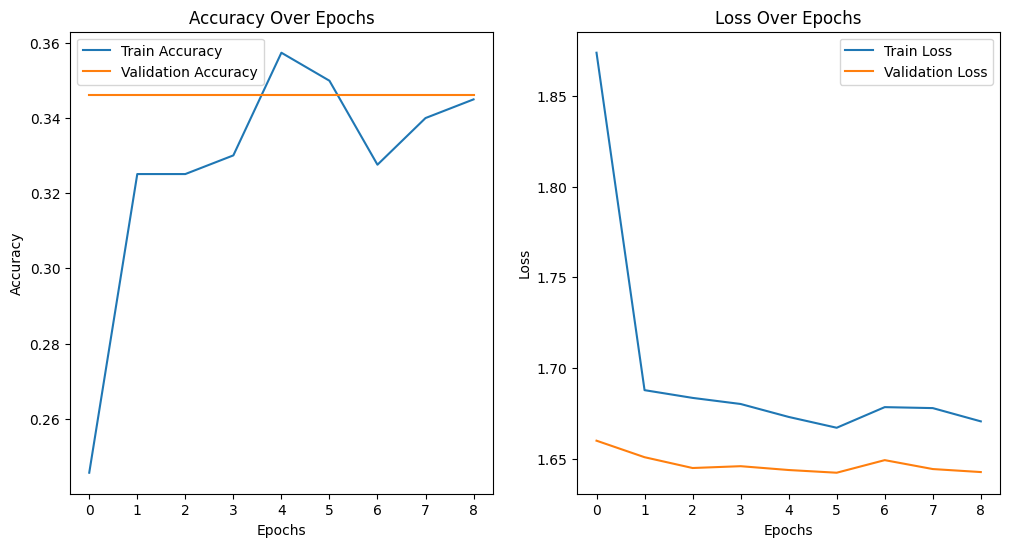

In [14]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [ ]:
# Save the model
model.save("thermal_plant_resnet_model.h5")
print("Model saved.")